In [1]:
import pandas as pd
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.externals.six import StringIO 
from sklearn import preprocessing
from IPython.display import Image 
from sklearn.tree import export_graphviz
import pydotplus
import numpy as np
import matplotlib.pyplot as plt
import copy 

In [2]:
hockey = pd.read_csv('./hockey/join_skater_and_season_stats_10_years_view.csv')
#hockey.head(3)
#hockey['DraftYear'].apply(lambda x: x.replace(',',''))
hockey['DraftYear'] = hockey['DraftYear'].replace(',','', regex=True)

#hockey['DraftYear'] = pd.to_numeric(hockey['DraftYear'], errors='coerce').fillna(0).astype(np.int64)
hockey['DraftYear'] = hockey['DraftYear'].astype(str).astype(int)
hockey['DraftYear'].dtype


dtype('int64')

In [3]:
def print_prune_tree(t, thresh,root=0, depth=1, parent_probability = [], parent = 0):
    if depth == 1:
        print('def predict(X_i):')
    indent = '    '*depth
    print(indent + '# node %s: impurity = %.2f' % (str(root), t.impurity[root]))
    node_probability = t.value[root]/np.sum(t.value[root])
    left_child = t.children_left[root]
    right_child = t.children_right[root]
    
    if left_child == sklearn.tree._tree.TREE_LEAF:
        print(indent + 'return %s # (node %d)' % (str(t.value[root]), root))
        ## Added "1" to ensure division by 0 does not occur
        expected = parent_probability*np.sum(t.value[root])+1
        chi = np.sum(np.divide(np.square(np.subtract(expected, t.value[root]+1)),expected))
        print(chi)
        if chi <= thresh:
            print('Pruned')
            t.children_left[parent] = sklearn.tree._tree.TREE_LEAF

        
    else:
        print(indent + 'if X_i[%d] < %.2f: # (node %d)' % (t.feature[root], t.threshold[root], root))
        print_prune_tree(t, thresh, root=left_child, depth=depth+1,parent_probability = node_probability, parent = root)
        
        print(indent + 'else:')
        print_prune_tree(t,thresh, root=right_child, depth=depth+1,parent_probability = node_probability, parent = root)

In [4]:
def prune_tree(t, thresh,root=0, depth=1, parent_probability = [], parent = 0):
    node_probability = t.value[root]/np.sum(t.value[root])
    left_child = t.children_left[root]
    right_child = t.children_right[root]
    
    if left_child == sklearn.tree._tree.TREE_LEAF:
        ## Added "1" to ensure division by 0 does not occur
        expected = parent_probability*np.sum(t.value[root])+1
        chi = np.sum(np.divide(np.square(np.subtract(expected, t.value[root]+1)),expected))
        if chi <= thresh:
            t.children_left[parent] = sklearn.tree._tree.TREE_LEAF        
    else:
        prune_tree(t, thresh, root=left_child, depth=depth+1,parent_probability = node_probability, parent = root)
        prune_tree(t,thresh, root=right_child, depth=depth+1,parent_probability = node_probability, parent = root)

In [5]:
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [6]:
from IPython.display import SVG
from graphviz import Source
# import graphviz
from IPython.display import display                               
from ipywidgets import interactive
from sklearn import tree

In [7]:
def plot_tree(crit, split, depth, min_split, max_feature, min_leaf=0.2):
#     split = 'custom'
    y = hockey['rs_GP']
    features = ['DraftYear','rs_PlusMinus']
    y1 = y.copy()
    for i in range(len(y)):
        if y[i] > 0:
            y1[i] = 1

    x = hockey[features]
    
    estimator = DecisionTreeClassifier(random_state = 0 
      , criterion = crit
      , splitter = split
      , max_depth = int(depth)
      , min_samples_split=min_split
      , min_samples_leaf=min_leaf
      , max_features = max_feature)
    
    estimator.fit(x,y1)
    
    graph = Source(tree.export_graphviz(estimator
      , out_file=None
      , feature_names=features
      , filled = True))
   
    display(SVG(graph.pipe(format='svg')))
    return estimator

inter=interactive(plot_tree 
   , crit = ["gini", "entropy"]
   , split = ["best", "random"]
   , depth=(1,10)
   , min_split=(0.1,1)
   , min_leaf=(0.1,0.5)
   , max_feature = (1,2) )
display(inter)

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

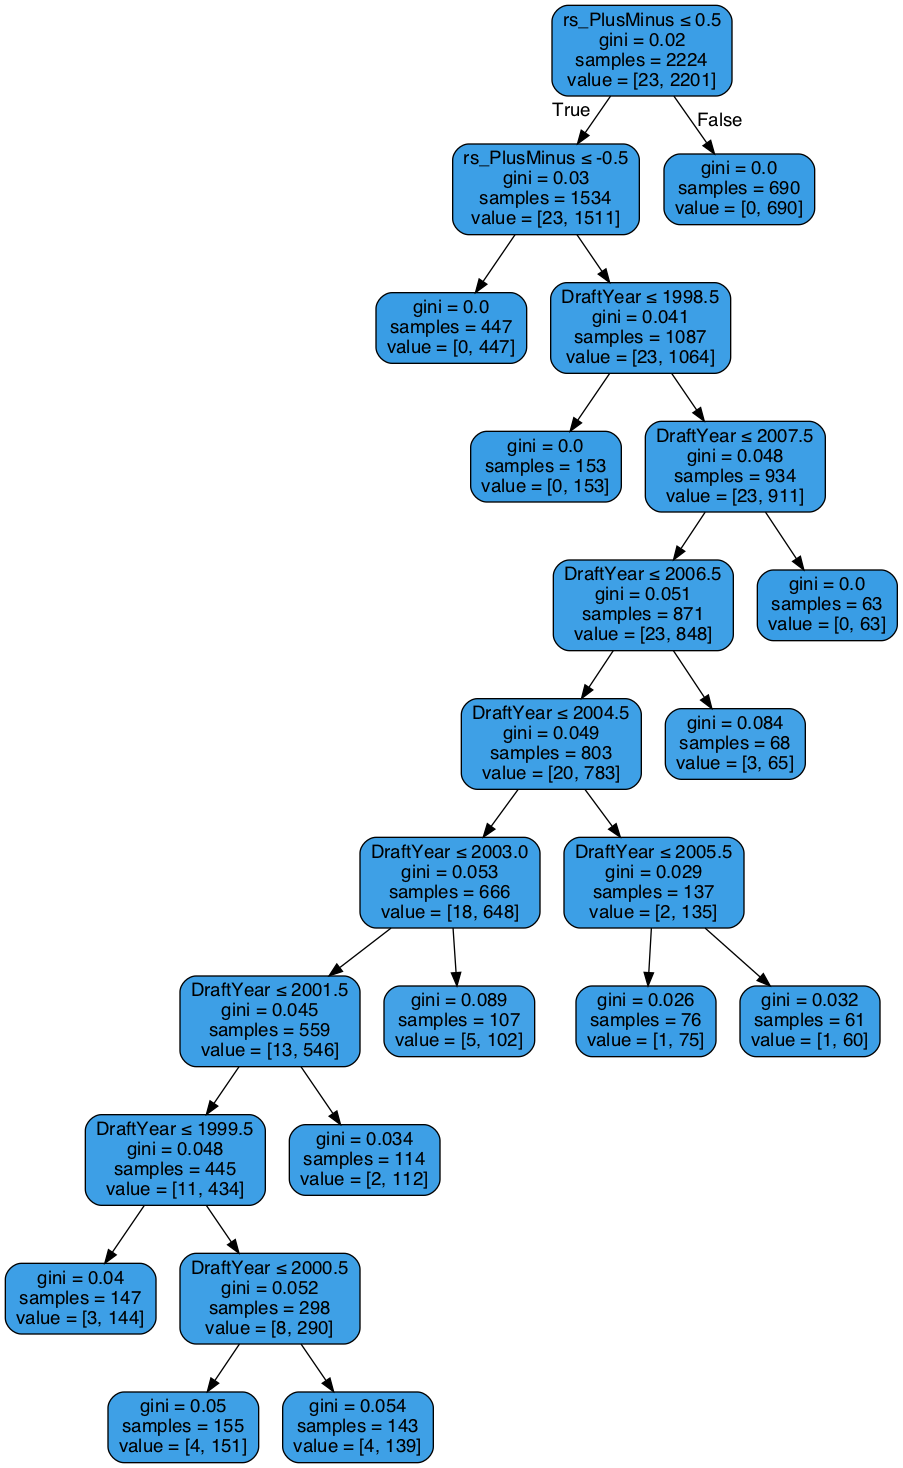

In [8]:
dtree=DecisionTreeClassifier()
y = hockey['rs_GP']
y1 = y.copy()
for i in range(len(y)):
    if y[i] > 0:
        y1[i] = 1
features = ['DraftYear','rs_PlusMinus']
x = hockey[features]
dtree.fit(x,y1)
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,feature_names=features,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

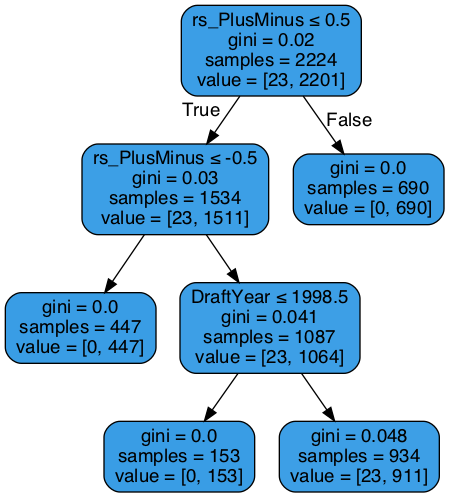

In [9]:
dtree_prune = DecisionTreeClassifier()
dtree_prune.fit(x,y1)
prune_tree(dtree_prune.tree_,1)
dot_data_prune = StringIO()
export_graphviz(dtree_prune, out_file=dot_data_prune,  
                filled=True, rounded=True,feature_names=features,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data_prune.getvalue())  
Image(graph.create_png())

In [10]:
#print x
print(len(y))

2224
